<a href="https://colab.research.google.com/github/VitorSRamos/NormFlows_StrongLensing/blob/main/image_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neste notebook vamos gerar o conjunto de imagens usadas no trabalho usando o pacote deeplenstronomy

In [ ]:
!pip install deeplenstronomy --quiet

import deeplenstronomy.deeplenstronomy as dl
from deeplenstronomy.visualize import view_image_rgb

import pandas as pd

import numpy as np

O deeplenstronomy funciona a partir de um arquivo de configuração, onde especificamos os parâmetros que desejamos para as simulações. O arquivo de configuração deve ser feito separadamente.

In [ ]:
config_file = 'delve_6params_config.yaml'

# printando o arquivo para avaliação
! cat delve_6params_config.yaml

DATASET:
    NAME: MyDeeplenstronomyDataset
    PARAMETERS:
        SIZE: 10001 # o programa gera uma imagem a menos do que especificado, por isso o 1 no final
        OUTDIR: SimulationResults
    SEED: 42     # Para reproducibilidade

COSMOLOGY:
    PARAMETERS:
        H0: 70
        Om0: 0.3

SPECIES:
    GALAXY_1:
        NAME: LENS # vamos especificar as caracteristicas da galaxia lente
        LIGHT_PROFILE_1:
            NAME: SERSIC_ELLIPSE
            PARAMETERS: # estes parametros ficam fixos na simulacao
                magnitude: 22
                R_sersic: 1 # Half-light Radius
                n_sersic: 2
                e1: 0
                e2: 0

        MASS_PROFILE_1:
            NAME: SIE
            PARAMETERS:
                # quando especificamos sigma_v, theta_E e calculado
                sigma_v: # Estes params sao retirados de uma distribuicao normal
                    DISTRIBUTION:
                        NAME: uniform 
                        PARAMETERS:


geramos o dataset com a função make_dataset. Estamos usando a configuração de imagem do [delve](https://delve-survey.github.io/), modificada para retornar imagens 64x64 nas bandas gri. Tudo isto está especificado no arquivo de configuração

In [ ]:
dataset = dl.make_dataset(config_file, verbose=True) # survey='delve' não é necessário porque já está no config

Entering main organization loop
Organizing CONFIGURATION_1
Generating images for CONFIGURATION_1
	Progress: 100.0 %  ---  Elapsed Time: 0 H 4 M 38 S         


essa função retorna o objeto dataset que tem dois elementos, um pandas DataFrame com os parâmetros de cada imagem e um numpy array com as imagens  

In [ ]:
print(type(dataset.CONFIGURATION_1_metadata))

print(type(dataset.CONFIGURATION_1_images))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


Vamos criar um subset do dataframe contendo as colunas relevantes. Podemos aproveitar para renomear as colunas com nomes mais simples.

In [ ]:
data = dataset.CONFIGURATION_1_metadata[[
    'PLANE_1-OBJECT_1-MASS_PROFILE_1-sigma_v-g', # dispersão de velocidade
    'PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g', # raio de einstein
    'PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g', # elipticidade 1
    'PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g', # elipticidade 2
    'PLANE_1-REDSHIFT-g', # redshift da lente
    'PLANE_2-REDSHIFT-g', # redshift da fonte 
]]

col_names = {
        'PLANE_1-OBJECT_1-MASS_PROFILE_1-sigma_v-g':'sigmaV', 
        'PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g':'thetaE', 
        'PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g':'le1', 
        'PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g':'le2', 
        'PLANE_1-REDSHIFT-g':'zl', 
        'PLANE_2-REDSHIFT-g':'zs', 
}

data.rename(columns = col_names, inplace=True)

display(data[0:5])

,sigmaV,thetaE,le1,le2,zl,zs
0,370.012688,1.750460,-0.330625,0.084682,0.244386,0.621237
1,370.579310,1.948625,0.278435,0.006698,0.370930,0.734340
2,267.810022,0.983542,-0.125725,0.397823,0.314473,0.682789
3,165.402561,0.514583,-0.216904,0.212130,0.306924,0.639115
4,154.546881,0.294719,-0.168803,0.372805,0.220196,0.723086


Pegamos os valores referentes às imagens na banda g, mas note que eles são iguais nas outras as bandas:

In [ ]:
data_r = dataset.CONFIGURATION_1_metadata[[
    'PLANE_1-OBJECT_1-MASS_PROFILE_1-sigma_v-r', # dispersão de velocidade
    'PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-r', # raio de einstein
    'PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-r', # elipticidade 1
    'PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-r', # elipticidade 2
    'PLANE_1-REDSHIFT-r', # redshift da lente
    'PLANE_2-REDSHIFT-r', # redshift da fonte 
]]

display(data_r[0:5])

,PLANE_1-OBJECT_1-MASS_PROFILE_1-sigma_v-r,PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-r,PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-r,PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-r,PLANE_1-REDSHIFT-r,PLANE_2-REDSHIFT-r
0,370.012688,1.750460,-0.330625,0.084682,0.244386,0.621237
1,370.579310,1.948625,0.278435,0.006698,0.370930,0.734340
2,267.810022,0.983542,-0.125725,0.397823,0.314473,0.682789
3,165.402561,0.514583,-0.216904,0.212130,0.306924,0.639115
4,154.546881,0.294719,-0.168803,0.372805,0.220196,0.723086


agora vamos olhar para as imagens. O array tem formato (n_imagens, n_bandas, largura, altura)

In [ ]:
images = dataset.CONFIGURATION_1_images

print(images.shape)

(10000, 3, 64, 64)


Alguns exemplos de imagens

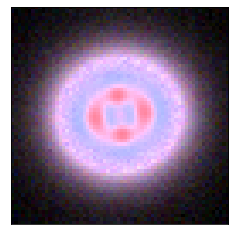

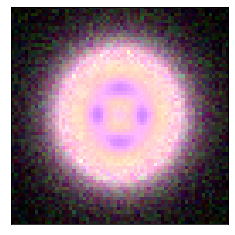

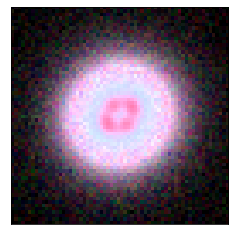

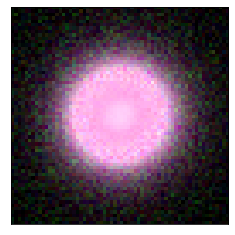

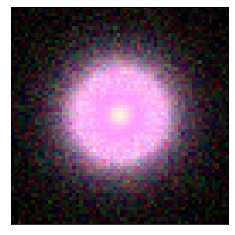

In [ ]:
for i in range(5):
    view_image_rgb(images[i])


Por fim, vamos salvar as imagens e a tabela em arquivos para serem usados em outros notebooks

In [ ]:
# Versão do github

# Salvamos as imagens como um arquivo npy
np.save('delve_6params_images.npy', images)

# Salvamos a tabela como um csv
data.to_csv('delve_6params_table.csv', index=False)

Agora, verficando os arquivos salvos

In [ ]:
# Apagando objetos anteriores
del images
del data

,sigmaV,thetaE,le1,le2,zl,zs
0,370.012688,1.750460,-0.330625,0.084682,0.244386,0.621237
1,370.579310,1.948625,0.278435,0.006698,0.370930,0.734340
2,267.810022,0.983542,-0.125725,0.397823,0.314473,0.682789
3,165.402561,0.514583,-0.216904,0.212130,0.306924,0.639115
4,154.546881,0.294719,-0.168803,0.372805,0.220196,0.723086


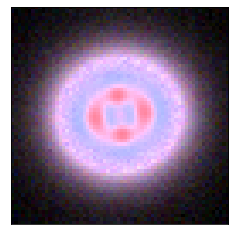

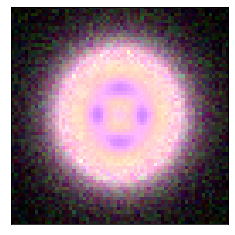

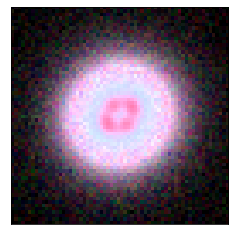

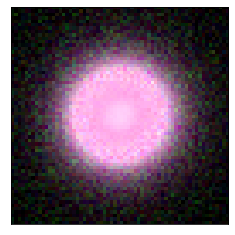

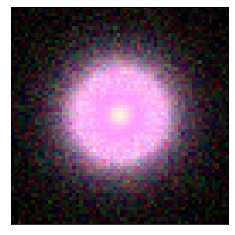

In [ ]:
new_table = pd.read_csv('delve_6params_table.csv')
new_images = np.load('delve_6params_images.npy')

display(new_table[0:5])

for i in range(5):
    view_image_rgb(new_images[i])